In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from lcc import lcc

# import torch
# import torch.nn as nn
# import torch.optim as optim

from tqdm.notebook import tqdm

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from torch.nn.functional import pad
# from torch.utils.data import DataLoader
# from torchvision import models
# from torchvision.datasets import ImageFolder

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (8, 6)
fontsize = 18
figsize = (8, 6)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
seed_everything()

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

In [3]:
num_samples, num_features = 1600, 23

true_weight = np.random.randint(0, 40, (num_features,))
X_train = np.random.randint(0, 40, (num_samples, num_features))

y_train = X_train.dot(true_weight)
print(X_train.shape, true_weight.shape, y_train.shape)

(1600, 23) (23,) (1600,)


In [4]:
# def primes_by_precision(n_bits=24, precision=16, n_features=500, max_abs=100):
#     low   = 2 ** (precision + 1) * max_abs + 1
#     high  = np.iinfo('int64').max - 1
#     n = 2 ** n_bits + 1
#     sieve = [True] * (n + 1)
#     good  = []
#     for p in tqdm(range(2, n + 1)):
#         if (sieve[p]):
#             if p >= low and n_features * (p - 1) ** 2 <= high:
#                 good.append(p)
#             for i in range(p, n + 1, p):
#                 sieve[i] = False
#     del sieve
#     return good

# precision = 12
# n_bits = 25
# primes = primes_by_precision(n_bits, precision, num_features, np.abs(X_train).max())

# plt.hist(primes, bins=100)
# prime_number = primes[-1]
# del primes
# prime_number.bit_length()

In [5]:
prime_number = 2 ** 26 - 5
n_bits = prime_number.bit_length()

In [6]:
quantization_error = []
n_bits_range = np.arange(n_bits)
for l in tqdm(n_bits_range):
    quantization_error.append(np.linalg.norm(X_train - lcc.dequantize(lcc.quantize(X_train, l, prime_number), l, prime_number)))

  0%|          | 0/26 [00:00<?, ?it/s]

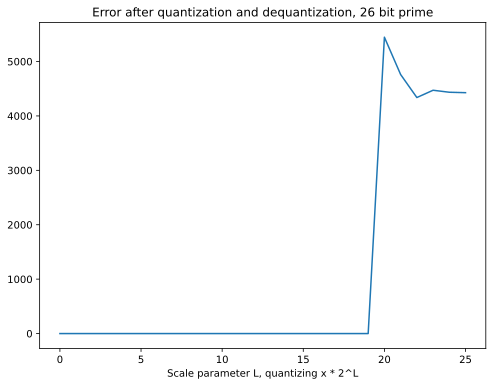

In [7]:
plt.title(f"Error after quantization and dequantization, {n_bits} bit prime")
plt.xlabel("Scale parameter L, quantizing x * 2^L")
plt.plot(n_bits_range, quantization_error);

In [8]:
precision = 4

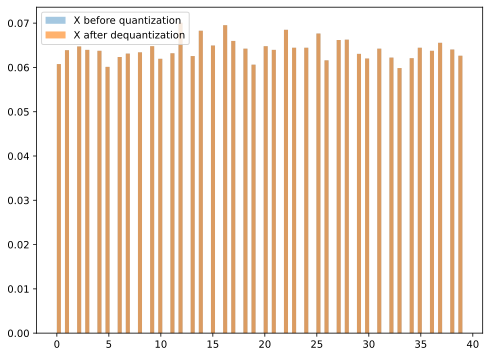

In [9]:
plt.hist(X_train.flatten(), bins=100, density=True, label="X before quantization", alpha=.4)
plt.hist(lcc.dequantize(lcc.quantize(X_train, precision, prime_number), precision, prime_number).flatten(), alpha=0.6, bins=100, density=True, label="X after dequantization")
plt.legend();

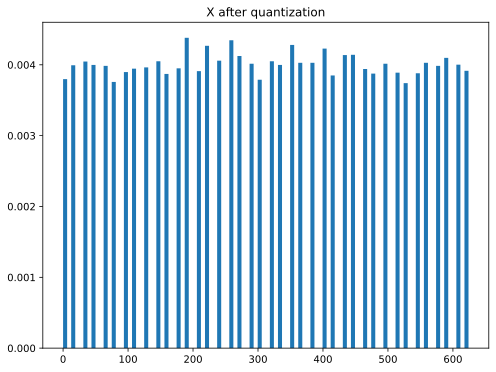

In [10]:
X_q = lcc.quantize(X_train, precision, prime_number).flatten()
plt.hist(X_q, bins=100, density=True)
plt.title("X after quantization");

In [11]:
# X_q = lcc.quantize(X_train, precision, prime_number).flatten()
# plt.hist(X_q[X_q < np.quantile(X_q, 0.4)], bins=50, density=True, label="x, x > 0")
# plt.hist(prime_number - X_q[X_q >= np.quantile(X_q, 0.6)], bins=50, density=True, label="p-x, x <= 0")
# plt.legend()
# plt.title("X after quantization");

In [12]:
class BaseSmoothOracle(object):
    """
    Base class for smooth function.
    """

    def func(self, x):
        """
        Computes the value of function at point x.
        """
        raise NotImplementedError('Func is not implemented.')

    def grad(self, x):
        """
        Computes the gradient vector at point x.
        """
        raise NotImplementedError('Grad is not implemented.')


In [13]:
class LCCLeastSquaresOracle(BaseSmoothOracle):
    """
    LCC oracle for least-squares regression.
        f(x) = 0.5 ||Xw - y||_2^2
    """
    def __init__(self, X, y, prime_number,
                num_workers=40,
                num_stragglers=5,
                security_guarantee=2,
                privacy_guarantee=2,
                precision=16):
        self.X = X
        self.y = y
        self.XTy = X.T.dot(y)
        self.Xq = lcc.quantize(X, precision, prime_number)
        self.yq = lcc.quantize(y, precision, prime_number)

        self.num_workers = num_workers # N
        self.num_stragglers = num_stragglers # S
        self.security_guarantee = security_guarantee # A
        self.privacy_guarantee = privacy_guarantee # T
        self.prime_number = prime_number
        self.precision = precision

        self._init_num_batches() # K
        self._precomputation()

    def _init_num_batches(self):
        self.poly_degree = 2 # X.T.dot(X)
        self.num_batches = (self.num_workers - 1 - 2 * self.security_guarantee \
                           - self.num_stragglers) // self.poly_degree + 1 - self.privacy_guarantee
        m, _ = self.X.shape
        while m % self.num_batches:
            self.num_batches -= 1
        self.n_bound = (self.num_batches + self.privacy_guarantee - 1) * self.poly_degree \
                       - self.num_stragglers + 2 * self.security_guarantee + 1 
        print(f"Initialized K={self.num_batches} batches")
        print(f"Numbers of workers to restore correctly: N>={self.n_bound}")

    def _precomputation(self):
        n_betas = self.num_batches + self.privacy_guarantee
        n_alphas = self.num_workers
        self.alphas = (np.arange(n_alphas) + 1).astype("int64")
        self.betas = (np.arange(n_betas) + 1 + n_alphas).astype("int64")
        self.U = lcc.gen_Lagrange_coeffs(self.alphas, self.betas, self.prime_number)
        Xq_split = np.stack(np.split(self.Xq, self.num_batches))
        self.Z = np.random.randint(0, self.prime_number, 
                                   (self.privacy_guarantee, *Xq_split.shape[1:])).astype("int64")
        X_to_encode = np.concatenate([Xq_split, self.Z])
        self.X_encoded = np.mod(np.einsum("kn,kmd->nmd", self.U, X_to_encode), self.prime_number) # N x (m // K) x d

    def _worker_func(self, X, w):
        wq = lcc.quantize(w, self.precision, self.prime_number)
        return np.mod(X.dot(wq), self.prime_number) # (N - S) x (m // K)

    def func(self, w):
        succeeded_workers = np.random.choice(self.num_workers, 
                                             self.num_workers - self.num_stragglers, 
                                             replace=False)
        func_encoded = self._worker_func(self.X_encoded[succeeded_workers], w)
        if self.security_guarantee > 0:
            raise NotImplementedError("Adversarial decoding not yet supported!")
        else:
            U_dec = lcc.gen_Lagrange_coeffs(self.betas[:self.num_batches], 
                                            self.alphas[succeeded_workers], 
                                            self.prime_number)
            func_decoded = np.mod(np.einsum("nk,nm->km", U_dec, func_encoded), self.prime_number)
            self.worker_func = lcc.dequantize(func_decoded, self.precision, self.prime_number)
        return 0.5 * ((self.worker_func.reshape(-1) - self.y) ** 2).mean()

    def _debug_func(self, w):
        return 0.5 * ((self.X.dot(w) - self.y) ** 2).mean()

    def _worker_grad(self, X, w):
        wq = lcc.quantize(w, self.precision, self.prime_number)
        Xw = np.mod(np.einsum('nmd,d->nm', X, wq), self.prime_number) # (N - S) x d
        return np.mod(np.einsum('nmd,nm->nd', X, Xw), self.prime_number) # (N - S) x d

    def grad(self, w):
        succeeded_workers = np.random.choice(
            self.num_workers, 
            self.num_workers - self.num_stragglers, 
            replace=False)
        grad_encoded = self._worker_grad(self.X_encoded[succeeded_workers], w)
        if self.security_guarantee > 0:
            malicious_workers = np.random.choice(
                list(set(range(num_workers)) - set(succeeded_workers)), 
                self.security_guarantee, replace=False)
            raise NotImplementedError("Adversarial decoding not yet supported!")
        else:
            U_dec = lcc.gen_Lagrange_coeffs(self.betas[:self.num_batches], 
                                            self.alphas[succeeded_workers], 
                                            self.prime_number)
            grad_decoded = np.mod(np.einsum("nk,nd->kd", U_dec, grad_encoded), self.prime_number)
            grad_decoded = np.mod(grad_decoded.sum(0), self.prime_number)
            self.worker_grad = lcc.dequantize(grad_decoded, self.precision, self.prime_number)
        return (self.worker_grad - self.XTy) / len(self.X)
    
    def _debug_grad(self, w):
        return self.X.T.dot(self.X.dot(w) - self.y) / len(self.X)

In [14]:
class LCCMatMul():
    """
    LCC matrix multiplication A.T.dot(B)
    """
    def __init__(self, A, B, prime_number,
                num_workers=40,
                num_stragglers=5,
                security_guarantee=2,
                privacy_guarantee=2,
                precision=16):
        self.A = A
        self.B = B
        self.Aq = lcc.quantize(A, precision, prime_number)
        self.Bq = lcc.quantize(B, precision, prime_number)

        self.num_workers = num_workers # N
        self.num_stragglers = num_stragglers # S
        self.security_guarantee = security_guarantee # A
        self.privacy_guarantee = privacy_guarantee # T
        self.prime_number = prime_number
        self.precision = precision

        self._init_num_batches() # K
        self._precomputation()

    def _init_num_batches(self):
        self.poly_degree = 4 # X.T.dot(X)
        self.num_batches = (self.num_workers - 1 - 2 * self.security_guarantee \
                           - self.num_stragglers) // self.poly_degree + 1 - self.privacy_guarantee
        m, _ = self.X.shape
        while m % self.num_batches:
            self.num_batches -= 1
        self.n_bound = (self.num_batches + self.privacy_guarantee - 1) * self.poly_degree \
                       - self.num_stragglers + 2 * self.security_guarantee + 1 
        print(f"Initialized K={self.num_batches} batches")
        print(f"Numbers of workers to restore correctly: N>={self.n_bound}")

    def _precomputation(self):
        n_betas = self.num_batches + self.privacy_guarantee
        n_alphas = self.num_workers
        self.alphas = (np.arange(n_alphas) + 1).astype("int64")
        self.betas = (np.arange(n_betas) + 1 + n_alphas).astype("int64")
        self.U = lcc.gen_Lagrange_coeffs(self.alphas, self.betas, self.prime_number)
        Xq_split = np.stack(np.split(self.Xq, self.num_batches))
        self.Z = np.random.randint(0, self.prime_number, 
                                   (self.privacy_guarantee, *Xq_split.shape[1:])).astype("int64")
        X_to_encode = np.concatenate([Xq_split, self.Z])
        self.X_encoded = np.mod(np.einsum("kn,kmd->nmd", self.U, X_to_encode), self.prime_number) # N x (m // K) x d

    def _worker_func(self, X, w):
        wq = lcc.quantize(w, self.precision, self.prime_number)
        return np.mod(X.dot(wq), self.prime_number) # (N - S) x (m // K)

    def func(self, w):
        succeeded_workers = np.random.choice(self.num_workers, 
                                             self.num_workers - self.num_stragglers, 
                                             replace=False)
        func_encoded = self._worker_func(self.X_encoded[succeeded_workers], w)
        if self.security_guarantee > 0:
            raise NotImplementedError("Adversarial decoding not yet supported!")
        else:
            U_dec = lcc.gen_Lagrange_coeffs(self.betas[:self.num_batches], 
                                            self.alphas[succeeded_workers], 
                                            self.prime_number)
            func_decoded = np.mod(np.einsum("nk,nm->km", U_dec, func_encoded), self.prime_number)
            self.worker_func = lcc.dequantize(func_decoded, self.precision, self.prime_number)
        return 0.5 * ((self.worker_func.reshape(-1) - self.y) ** 2).mean()

    def _debug_func(self, w):
        return 0.5 * ((self.X.dot(w) - self.y) ** 2).mean()

In [15]:
num_samples, num_features = 25000, 50
low, high = -10, 10

true_weight = np.random.randint(low, high, (num_features,))
X_train = np.random.randint(low, high, (num_samples, num_features))
y_train = X_train.dot(true_weight)
print(X_train.shape, true_weight.shape, y_train.shape)

random_weight = np.random.randint(low, high, (num_features,))

(25000, 50) (50,) (25000,)


In [16]:
num_workers = 30
num_stragglers = 1
security_guarantee = 0
privacy_guarantee = 1
precision = 0 # no quantization
prime_number = 2 ** 26 - 5

oracle = LCCLeastSquaresOracle(X_train, y_train, prime_number,
                               num_workers=num_workers,
                               num_stragglers=num_stragglers,
                               security_guarantee=security_guarantee,
                               privacy_guarantee=privacy_guarantee,
                               precision=precision)

Initialized K=10 batches
Numbers of workers to restore correctly: N>=20


In [17]:
succeeded_workers = np.random.choice(oracle.num_workers, oracle.num_workers - oracle.num_stragglers, replace=False)
U = lcc.gen_Lagrange_coeffs(oracle.alphas, oracle.betas, oracle.prime_number)
Uinv = lcc.gen_Lagrange_coeffs(oracle.betas[:oracle.num_batches], oracle.alphas[succeeded_workers], oracle.prime_number)
np.mod(U[:, succeeded_workers].dot(Uinv), oracle.prime_number)[:oracle.num_batches]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [18]:
# no bit overflow
int(U[:, succeeded_workers].dot(Uinv).max()).bit_length()

56

In [19]:
X_decoded = np.mod(np.einsum("nk,nmd->kmd", Uinv, oracle.X_encoded[succeeded_workers]), oracle.prime_number)
X_decoded = lcc.dequantize(X_decoded, oracle.precision, oracle.prime_number)
X_decoded = X_decoded.reshape(-1, X_decoded.shape[-1])
np.linalg.norm(X_decoded - oracle.X)

0.0

In [20]:
Xw = np.einsum("nmd,d->nm", oracle.X_encoded[succeeded_workers],
               lcc.quantize(random_weight, oracle.precision, oracle.prime_number))
Xw = np.mod(Xw, oracle.prime_number)
Xw_decoded = np.mod(np.einsum("nk,nm->km", Uinv, Xw), oracle.prime_number)
Xw_decoded = lcc.dequantize(Xw_decoded, oracle.precision, oracle.prime_number)
Xw_decoded = Xw_decoded.reshape(-1)
np.linalg.norm(Xw_decoded - oracle.X.dot(random_weight))

0.0

In [21]:
# XTX = np.einsum("nml,nmd->nld", oracle.X_encoded[succeeded_workers], oracle.X_encoded[succeeded_workers])
# XTX = np.mod(XTX, oracle.prime_number)
# XTX_decoded = np.mod(np.einsum("nk,nld->ld", Uinv, XTX), oracle.prime_number)
# XTX_decoded = lcc.dequantize(XTX_decoded, oracle.precision, oracle.prime_number)
# np.linalg.norm(XTX_decoded - oracle.X.T.dot(oracle.X))

In [22]:
oracle.X_encoded.shape

(30, 2500, 50)

In [23]:
oracle.func(true_weight), oracle._debug_func(true_weight)

(0.0, 0.0)

In [24]:
oracle.func(random_weight), oracle._debug_func(random_weight)

(49648.61862, 49648.61862)

In [25]:
oracle.grad(true_weight)[:10], oracle._debug_grad(true_weight)[:10]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [26]:
oracle.grad(random_weight)[:10], oracle._debug_grad(random_weight)[:10]

(array([  57.31568,   48.78196,  -41.85992,   36.588  ,  -62.61144,
         124.56448,  223.7518 , -367.76068, -363.65412, -337.79096]),
 array([  57.31568,   48.78196,  -41.85992,   36.588  ,  -62.61144,
         124.56448,  223.7518 , -367.76068, -363.65412, -337.79096]))

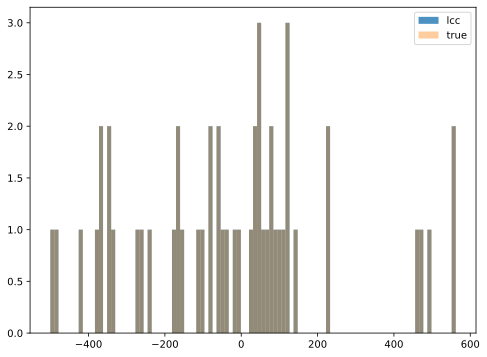

In [27]:
plt.hist(oracle.grad(random_weight), bins=100, alpha=0.8, label='lcc');
plt.hist(oracle._debug_grad(random_weight), bins=100, alpha=0.4, label='true');
plt.legend();

In [33]:
plt.rc("text", usetex=True)

import liboptpy.unconstr_solvers as solvers
import liboptpy.step_size as ss

In [30]:
max_iter = 1000
tol = 1e-10
# optim = solvers.fo.AcceleratedGD(oracle._debug_func, oracle._debug_grad, ss.Backtracking(rule_type="Lipschitz", rho=0.5, eps=1e-2, init_alpha=0.5))
optim = solvers.fo.AcceleratedGD(oracle._debug_func, oracle._debug_grad, ss.ConstantStepSize(1e-4))
w0 = np.zeros(num_features)
w_opt = optim.solve(w0, max_iter, tol, disp=True)
optim.convergence.append(w_opt)
f_vals = [oracle._debug_func(w) for w in optim.convergence]
grad_vals = [np.linalg.norm(oracle._debug_grad(w)) ** 2 for w in optim.convergence]

Maximum iteration exceeds!
Convergence in 1000 iterations
Function value = 2.719983495426559e-05
Norm of gradient = 0.0424786889971652


In [31]:
max_iter = 200
tol = 1e-10
optim = solvers.fo.AcceleratedGD(oracle.func, oracle.grad, ss.ConstantStepSize(1e-4))
w0 = np.zeros(num_features)
w_opt = optim.solve(w0, max_iter, tol, disp=True)
optim.convergence.append(w_opt)
coded_f_vals = [oracle.func(w) for w in optim.convergence]
coded_grad_vals = [np.linalg.norm(oracle.grad(w)) ** 2 for w in optim.convergence]

Required tolerance achieved!
Convergence in 79 iterations
Function value = 0.0
Norm of gradient = 0.0


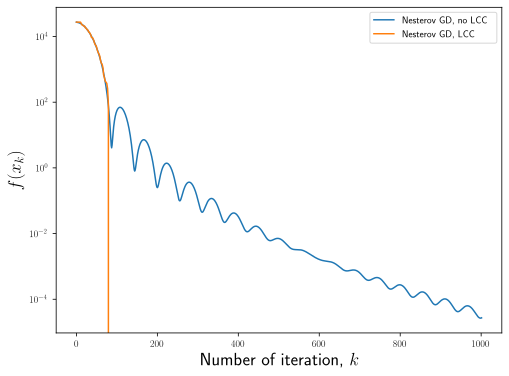

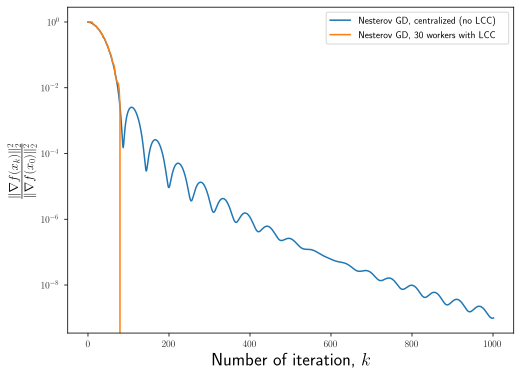

In [34]:
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(x_k)$", fontsize=fontsize)
plt.plot(f_vals, label='Nesterov GD, no LCC')
plt.plot(coded_f_vals, label='Nesterov GD, LCC')
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show();

plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\frac{\| \nabla f(x_k)\|^2_2}{\| \nabla f(x_0)\|^2_2}$", fontsize=fontsize)
plt.plot(grad_vals / grad_vals[0], label='Nesterov GD, centralized (no LCC)')
plt.plot(coded_grad_vals / coded_grad_vals[0], label='Nesterov GD, 30 workers with LCC')
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [35]:
num_samples, num_features = 24000, 500
cond_number = 10000

true_weight = np.random.randn(num_features)
X_train = np.random.randn(num_samples, num_features)

U, S, V = np.linalg.svd(X_train, full_matrices=False)
S_bad = S.copy()
S_bad[-1] = S_bad[0] / cond_number
X_train = (U.dot(np.diag(S_bad))).dot(V)
del U, S, V

y_train = X_train.dot(true_weight)
print(X_train.shape, true_weight.shape, y_train.shape)

(24000, 500) (500,) (24000,)


In [36]:
num_workers = 40
num_stragglers = 3
security_guarantee = 0
privacy_guarantee = 2

oracle = LCCLeastSquaresOracle(X_train, y_train, prime_number,
                               num_workers=num_workers,
                               num_stragglers=num_stragglers,
                               security_guarantee=security_guarantee,
                               privacy_guarantee=privacy_guarantee,
                               precision=precision)

Initialized K=16 batches
Numbers of workers to restore correctly: N>=32


In [43]:
max_iter = 1000
tol = 1e-10
optim = solvers.fo.AcceleratedGD(oracle._debug_func, oracle._debug_grad, ss.ConstantStepSize(1e-2))
w0 = np.zeros(num_features)
w_opt = optim.solve(w0, max_iter, tol, disp=True)
optim.convergence.append(w_opt)
f_vals = [oracle._debug_func(w) for w in optim.convergence]
grad_vals = [np.linalg.norm(oracle._debug_grad(w)) ** 2 for w in optim.convergence]

Maximum iteration exceeds!
Convergence in 1000 iterations
Function value = 6.764623539907601e-10
Norm of gradient = 1.2278317127761322e-05


In [44]:
max_iter = 1000
tol = 1e-10
optim = solvers.fo.AcceleratedGD(oracle.func, oracle.grad, ss.ConstantStepSize(1e-2))
w0 = np.zeros(num_features)
w_opt = optim.solve(w0, max_iter, tol, disp=True)
optim.convergence.append(w_opt)
coded_f_vals = [oracle._debug_func(w) for w in optim.convergence]
coded_grad_vals = [np.linalg.norm(oracle._debug_grad(w)) ** 2 for w in optim.convergence]

Maximum iteration exceeds!
Convergence in 1000 iterations
Function value = 66.18725718408336
Norm of gradient = 10.1684317160067


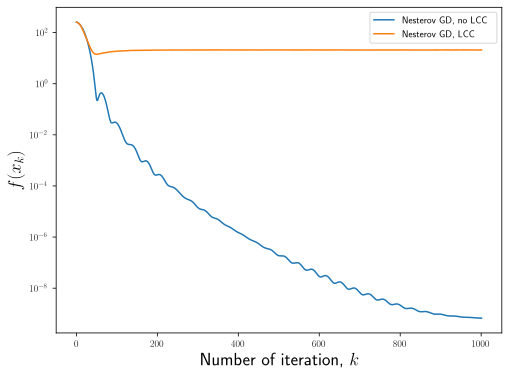

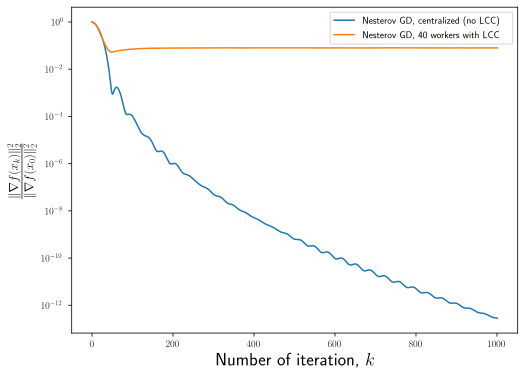

In [45]:
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(x_k)$", fontsize=fontsize)
plt.plot(f_vals, label='Nesterov GD, no LCC')
plt.plot(coded_f_vals, label='Nesterov GD, LCC')
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show();

plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\frac{\| \nabla f(x_k)\|^2_2}{\| \nabla f(x_0)\|^2_2}$", fontsize=fontsize)
plt.plot(grad_vals / grad_vals[0], label='Nesterov GD, centralized (no LCC)')
plt.plot(coded_grad_vals / coded_grad_vals[0], label='Nesterov GD, 40 workers with LCC')
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()